In [2]:
#既にインストールずみっぽいのでコメントアウト
#!pip install sklearn
!pip install lightGBM
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [3]:
# visual用のライブラリをインポート
import seaborn as sns; sns.set() # グラフ描画
import warnings # 警告を無視
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split # データセット分割
from sklearn.metrics import accuracy_score # モデル評価(正答率)
from sklearn.metrics import log_loss # モデル評価(logloss)     
from sklearn.metrics import roc_auc_score # モデル評価(auc)
from sklearn.metrics import r2_score # モデル評価(決定係数)
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [4]:
# ディシジョンツリー可視化用ライブラリのインストール
!pip install graphviz
from sklearn import tree
import graphviz


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


In [5]:
import pandas as pd
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.metrics import mean_squared_error,mean_squared_log_error
import numpy as np
input_data = pd.read_csv("./train.csv")
test_data = pd.read_csv("./test.csv") 
test_original_data = test_data.copy()
input_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [6]:
# 以下をベースにグリッドサーチ
#https://zenn.dev/nishimoto/articles/3b9c6411630836
# K分割公差検証かつグリッドサーチで汎化性能＋パラメータチューニングを行う
# hourは有効な数字なのでカテゴリ変数で性能変化を確かめる→変わらず
# 性能が出たらtrainとpredictの誤差を出して汎化誤差を可視化
# なぜパラメータがよくなるかを考察（rdとの比較）
# rfはアンサンブルしてもよいかも
# 提出用にグラフ化意識する

In [7]:
input_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
input_data.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [9]:
# datetimeを年月日時間曜日まで変換
input_data.datetime = pd.to_datetime(input_data.datetime)
test_data.datetime = pd.to_datetime(test_data.datetime)
# Add columns for month, hour, day and year
input_data['Year'] = input_data['datetime'].dt.year
input_data['month'] = input_data['datetime'].dt.month
input_data['day'] = input_data['datetime'].dt.day
input_data['hour'] = input_data['datetime'].dt.hour
input_data['weekday'] = input_data['datetime'].dt.weekday
input_data.head()

test_data['Year'] = test_data['datetime'].dt.year
test_data['month'] = test_data['datetime'].dt.month
test_data['day'] = test_data['datetime'].dt.day
test_data['hour'] = test_data['datetime'].dt.hour
test_data['weekday'] = test_data['datetime'].dt.weekday


In [10]:
# 訓練データと正解データの作成
y = input_data['count']
y_casual = input_data['casual']
y_registered = input_data['registered']
# 正解データ（count,registered,casual）及びdatetime、日にちは特徴量から省いて対応
input_data.drop('count', axis=1, inplace=True)
input_data.drop('casual', axis=1, inplace=True)
input_data.drop('registered', axis=1, inplace=True)
input_data.drop('day', axis=1, inplace=True)
input_data.drop('datetime', axis=1, inplace=True)

test_data.drop('datetime', axis=1, inplace=True)
test_data.drop('day', axis=1, inplace=True)

In [11]:
# lightGBMの特徴に従って前処理を行う。参考URLは以下。
# https://upura.hatenablog.com/entry/2019/10/29/184617

In [12]:
# 1欠損値の扱いについて:今回のデータに関しては、以下の通り欠損値無しのため特に関係ないが、
# lightGBMは欠損値がある特徴量もそのまま入力として扱えるメリットがある。
x= input_data.copy()
X_submit_test = test_data.copy() # 提出用データの整形。最後に使う。パラメータ調整などには使わない。
x.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   Year        10886 non-null  int64  
 9   month       10886 non-null  int64  
 10  hour        10886 non-null  int64  
 11  weekday     10886 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1020.7 KB


In [13]:
X_submit_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      6493 non-null   int64  
 1   holiday     6493 non-null   int64  
 2   workingday  6493 non-null   int64  
 3   weather     6493 non-null   int64  
 4   temp        6493 non-null   float64
 5   atemp       6493 non-null   float64
 6   humidity    6493 non-null   int64  
 7   windspeed   6493 non-null   float64
 8   Year        6493 non-null   int64  
 9   month       6493 non-null   int64  
 10  hour        6493 non-null   int64  
 11  weekday     6493 non-null   int64  
dtypes: float64(3), int64(9)
memory usage: 608.8 KB


In [14]:
# 2. カテゴリ変数の指定ができる
# カテゴリ変数を明示化する→明示化しても結果変わらず。ワンホットベクトル化してるわけではないので、そもそもカテゴリカルであり性能に変化がないのではと推測。
x.head()
categorical_features = ['Year','hour','month','season','weather','weekday']
#categorical_features = ['Year','hour','month','season','weather','weekday']

In [15]:
# 3. 特徴量のスケーリングが不要
# 決定木的に閾値を学習していくため、標準化は不要

In [16]:
#ひとまずはcountの推論を実施してみる。
#x_train,x_test,y_train_casual,y_test_casual = train_test_split(x,y_casual,test_size=0.2,random_state=42)
#x_train,x_test,y_train_registered,y_test_registered = train_test_split(x,y_registered,test_size=0.2,random_state=42)

In [17]:
def validate(train_x, train_y, params):
    # 下記を元にグリッドサーチ
    # https://dsf-kotaro.hatenablog.com/entry/2022/06/18/120000
    rmsle = []
    verbose_eval = 0 
    evaluation_results = {}  
    kf = KFold(n_splits=2, shuffle=True, random_state=0)
    for fold, (train_indices, valid_indices) in enumerate(kf.split(train_x)):
        X_train, X_valid = train_x.iloc[train_indices], train_x.iloc[valid_indices]
        y_train, y_valid = train_y.iloc[train_indices], train_y.iloc[valid_indices]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_valid, y_valid)

        verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
        evaluation_results = {}      
        gbm = lgb.train(params,
                        lgb_train,
                #categorical_feature=categorical_features,
                valid_sets=[lgb_train,lgb_eval],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                callbacks=[lgb.early_stopping(stopping_rounds=10, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )

        # スコア(RMSLE)算出
        y_pred = gbm.predict(X_valid)
        y_pred = np.where(y_pred < 0, 0, y_pred)
        rmsle.append(mean_squared_log_error(y_true=y_valid, y_pred=y_pred, squared=False))
        # 学習過程の可視化
        plt.plot(evaluation_results['train']['rmse'], label='train')
        plt.plot(evaluation_results['valid']['rmse'], label='valid')
        plt.ylabel('RMSLE')
        plt.xlabel('Boosting round')
        plt.title('Training performance')
        plt.legend()
        plt.show()
        print("parameters:{}, split number {}".format(params,fold))
    return rmsle

In [18]:
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import KFold
from tqdm import tqdm_notebook as tqdm
all_params = {
    'max_depth': [12,15,20],
    'learning_rate': [0.005,0.001],
    'n_estimetors': [10000],
    'num_leaves': [127, 255, 511,1024],
    'min_data_in_leaf': [3,5,10, 20,30],
    "bagging_fraction":[0.7,0.8,0.9],
    'bagging_freq': [1,3,5],
    'random_state': [42],
    "seed":[31],
    'boosting_type': ['gbdt'],
    'objective': ['regression'],
    'metric': ['rmse'],
    'verbose' : [-1],
    'lambda_l2':[0],
}
# Kfoldするかどうか
is_do_Kfold = False

# 学習用データセットの作成（X_test,y_testは最後のpredict用の変数としてここでは使用しない）
# dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
# dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
best_score = 50.0 # 最低値が欲しいので大きい値に設定しておく
best_params = {}

# Kfoldするかどうかを判定
if is_do_Kfold:
    for params in tqdm(ParameterGrid(all_params)):
        rmsle = validate(x, y, params)
        print("Kfold MLSLE = {}".format(rmsle))
        # もしaccuracyの平均値が最大だった場合、
        # best_scoreを更新して、best_paramsを更新する。
        if np.mean(rmsle) < best_score:
            best_score = np.mean(rmsle)
            best_params = params
    print("best score is following")
    print(best_score, best_params)
else:
    print("is_do_Kfold is false, so Kfold is not executed")

is_do_Kfold is false, so Kfold is not executed


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1948]	train's rmse: 18.3401	valid's rmse: 36.9948
elapse train time is 10.875829219818115
elapse predict time is 1.036722183227539
RMSE=36.13826085104274
RMSLE=0.3448341492464695


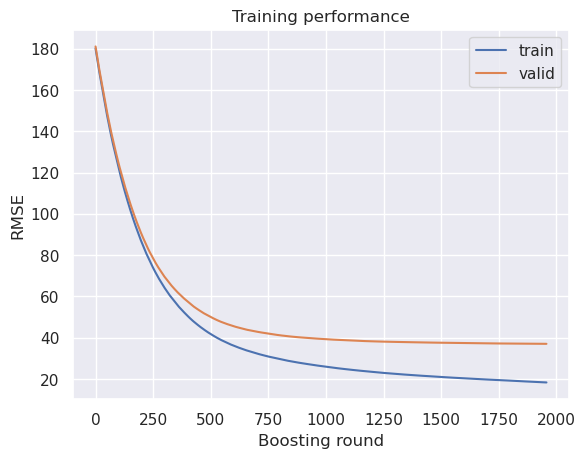

In [19]:
# 上のグリッドサーチで見つけたベストパラメータで全データでの学習、推論を行い結果を算出する。
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    "seed":31,
    'random_state': 42,
    'lambda_l2':5, # L2正則化をデフォルト1から5にして過学習の抑制を試みる。
    #'lambda_l1':100, # L1正則化をデフォルト1から5にして過学習の抑制を試みる。
    'verbose' : -1,
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    "learning_rate": 0.005, #学習率
    "num_leaves":511,
    "max_depth":12,
    "min_data_in_leaf":10,
    "bagging_fraction":0.8,
    "bagging_freq":1,
}
# グリッドサーチしない場合は上のいい感じのパラメータを反映する。
if len(best_params) == 0:
    best_params = params

# 学習データと検証データの分割
from sklearn.model_selection import train_test_split
# テストデータと学習データ分割
X_train_raw, X_test, y_train_raw, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
# early_stopping用の評価データをさらに分割
X_train, X_valid, y_train, y_valid = train_test_split(X_train_raw, y_train_raw, test_size=0.2, random_state=42)

# 学習用データセットの作成（X_test,y_testは最後のpredict用の変数としてここでは使用しない）
dtrain = lgb.Dataset(X_train, label=y_train)  # 学習用
dvalid = lgb.Dataset(X_valid, label=y_valid)  # early_stopping用
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evaluation_results = {} 
import time
starttime = time.time()
gbm = lgb.train(best_params,
                dtrain,
                #categorical_feature=categorical_features,
                valid_sets=[dtrain,dvalid],
                valid_names=['train', 'valid'],     
                num_boost_round = 10000,
                callbacks=[lgb.early_stopping(stopping_rounds=10, 
                                verbose=True), # early_stopping用コールバック関数
                           lgb.log_evaluation(verbose_eval),
                           lgb.record_evaluation(evaluation_results)] # コマンドライン出力用コールバック関数
                )
elapse_train_time = time.time() - starttime
print("elapse train time is {}".format(elapse_train_time))

# スコア(RMSE)算出
starttime = time.time()
y_pred = gbm.predict(X_test)
elapse_predict_time = time.time() - starttime
print("elapse predict time is {}".format(elapse_predict_time))

score_mlse = mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False)
print(f'RMSE={score_mlse}')
# MLSLEを算出するために、y_pred<0の場合に0を補完する
y_pred = np.where(y_pred < 0, 0, y_pred)
score_mlsle = mean_squared_log_error(y_true=y_test, y_pred=y_pred, squared=False)
print(f'RMSLE={score_mlsle}')

# 学習データに関してもRMSLEを算出してみる。
y_pred_train = gbm.predict(X_train)
# score_mlse = mean_squared_error(y_true=y_train, y_pred=y_pred_train, squared=False)
# print(f'RMSE train={score_mlse}')
# MLSLEを算出するために、y_pred<0の場合に0を補完する
y_pred_train = np.where(y_pred_train < 0, 0, y_pred_train)
# score_mlsle = mean_squared_log_error(y_true=y_train, y_pred=y_pred_train, squared=False)
# print(f'RMSLE train={score_mlsle}')
# 試行錯誤フェーズとして以下のURLを参考にレベルアップを目標とする。
# https://qiita.com/c60evaporator/items/351188110f328ff921b9
# 学習過程の可視化
plt.plot(evaluation_results['train']['rmse'], label='train')
plt.plot(evaluation_results['valid']['rmse'], label='valid')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training performance')
# plt.set_ylim(0, 180)
plt.legend()
plt.show()


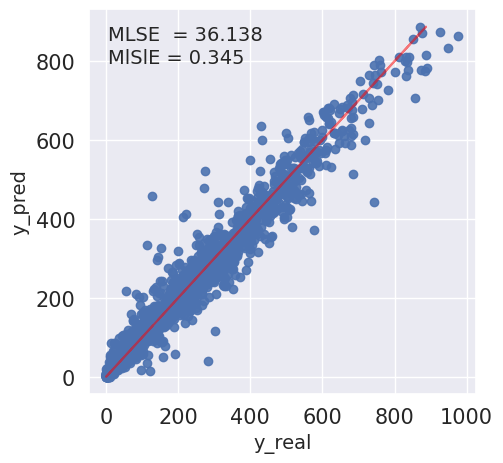

In [20]:
# テストデータで予測精度を確認
pred_df_light = pd.concat([y_test.reset_index(drop=True), pd.Series(y_pred)], axis = 1)
pred_df_light.columns = ['y_real', 'y_pred']
# 予測値グラフ化
def Prediction_accuracy(pred_df,score_mlse,score_mlsle):
    # MSE = mean_squared_error(pred_df['y_test'], pred_df['y_pred']) 
    # RMSE = np.sqrt(mean_squared_error(pred_df['y_test'], pred_df['y_pred']))
    # r2 = r2_score(pred_df['y_test'], pred_df['y_pred'])
    plt.figure(figsize = (5,5))
    ax = plt.subplot(111)
    ax.scatter('y_real', 'y_pred', data = pred_df,alpha=0.9)
    ax.set_xlabel('y_real', fontsize = 14)
    ax.set_ylabel('y_pred', fontsize = 14)
    plt.tick_params(labelsize = 15)
    ax.plot('y_pred','y_pred',data=pred_df,color='red',alpha =0.5)
    plt.text(0.05, 0.92, 'MLSE  = {}'.format(str(round(score_mlse,3))),transform = ax.transAxes, fontsize = 14)
    plt.text(0.05, 0.86, 'MlSlE = {}'.format(str(round(score_mlsle,3))),transform = ax.transAxes, fontsize = 14)
    # plt.text(0.05, 0.80, 'R²   = {}'.format(str(round(r2,3))),transform = ax.transAxes, fontsize = 14)

Prediction_accuracy(pred_df_light,score_mlse,score_mlsle)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

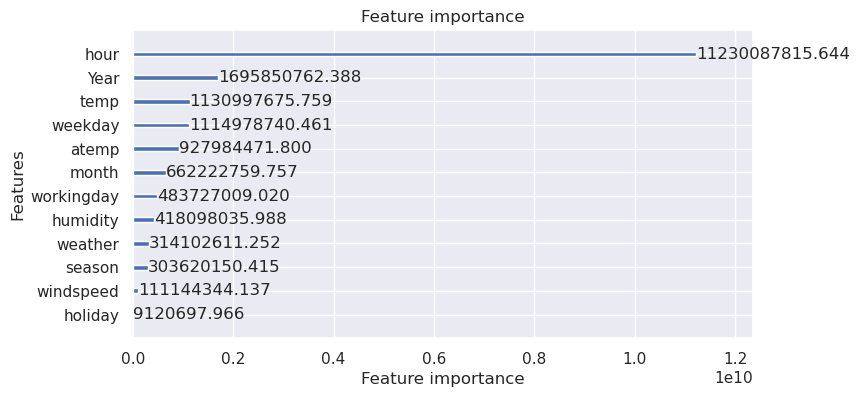

In [21]:
# 4. feature importanceが確認できる
# 特徴点（特徴量）の寄与率を明示化する。特徴点抽出
# 学習後、以下のURLを参考に寄与率を算出させてみる。
# https://qiita.com/ku_a_i/items/74241c84cda8c7327277
lgb.plot_importance(gbm, figsize=(8,4), max_num_features=15, importance_type='gain')

In [22]:
# 分割3、l2正則化デフォルトでグリッドサーチ
# Training until validation scores don't improve for 10 rounds
# Early stopping, best iteration is:
# [2298]	train's rmse: 15.9489	valid's rmse: 36.5446
# RMSE=35.078423180857826
# RMSLE=0.345137810488061
# RMSE train=15.94887472972294
# RMSLE train=0.2609591084642571
# best score is following
# 36.64531827628268 {'bagging_fraction': 0.8, 'bagging_freq': 1, 'boosting_type': 'gbdt', 'learning_rate': 0.005, 'max_depth': 12, 'metric': 'rmse', 'min_data_in_leaf': 10, 'n_estimetors': 10000, 'num_leaves': 127, 'objective': 'regression', 'random_state': 42, 'seed': 31, 'verbose': -1}
#提出スコア
#Score: 0.45498

In [23]:
# 5分割、l2正則化0で以下の結果。結果変わらないのは気になる。
# Training until validation scores don't improve for 10 rounds
# Early stopping, best iteration is:
# [2298]	train's rmse: 15.9489	valid's rmse: 36.5446
# RMSE=35.078423180857826
# RMSLE=0.345137810488061
# RMSE train=15.94887472972294
# RMSLE train=0.2609591084642571

In [24]:
# テストデータで推論
test_lightgbm = gbm.predict(X_submit_test)
# 提出用に、y_pred<0の場合に0を補完する
test_lightgbm = np.where(test_lightgbm < 0, 0, test_lightgbm)
out_lightgbm = pd.DataFrame({"datetime":test_original_data['datetime'], "count":test_lightgbm})
import datetime
time = datetime.datetime.now()
out_lightgbm.to_csv('output_lightbgm' + str(time) + '.csv', index = False)
print(X_train.columns.tolist())

['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed', 'Year', 'month', 'hour', 'weekday']


In [25]:
# 動かせず
#!pip install dtreeviz==1.3.1
# from dtreeviz.trees import *

# viz = dtreeviz(gbm,
#                x,
#                y,
#                target_name = "count",
#                feature_names = X_train.columns.tolist(),
#               tree_index = 0)

# viz
# # viz.save('./lgb_tree.svg')
# viz.view()
# https://github.com/parrt/dtreeviz
# https://github.com/parrt/dtreeviz/blob/master/notebooks/dtreeviz_lightgbm_visualisations.ipynb

In [26]:
# !pip install --force-reinstall graphviz==0.18
# lgb.plot_tree(gbm, tree_index=0,figsize=(150, 100));
# https://qiita.com/shimokame777/items/186d88a1aa298371936f


[0]	train-rmse:179.97044	eval-rmse:180.95738
[1]	train-rmse:179.13851	eval-rmse:180.14421
[2]	train-rmse:178.31080	eval-rmse:179.33563
[3]	train-rmse:177.48732	eval-rmse:178.53105
[4]	train-rmse:176.66802	eval-rmse:177.73165
[5]	train-rmse:175.85289	eval-rmse:176.93534
[6]	train-rmse:175.04188	eval-rmse:176.14497
[7]	train-rmse:174.23504	eval-rmse:175.35852
[8]	train-rmse:173.43229	eval-rmse:174.57636
[9]	train-rmse:172.63358	eval-rmse:173.80115
[10]	train-rmse:171.83889	eval-rmse:173.02431
[11]	train-rmse:171.04833	eval-rmse:172.25591
[12]	train-rmse:170.26169	eval-rmse:171.48793
[13]	train-rmse:169.47910	eval-rmse:170.72685
[14]	train-rmse:168.70018	eval-rmse:169.96858
[15]	train-rmse:167.92438	eval-rmse:169.21230
[16]	train-rmse:167.15240	eval-rmse:168.45999
[17]	train-rmse:166.38439	eval-rmse:167.71156
[18]	train-rmse:165.62048	eval-rmse:166.96753
[19]	train-rmse:164.86051	eval-rmse:166.22613
[20]	train-rmse:164.10414	eval-rmse:165.49117
[21]	train-rmse:163.35178	eval-rmse:164.7589

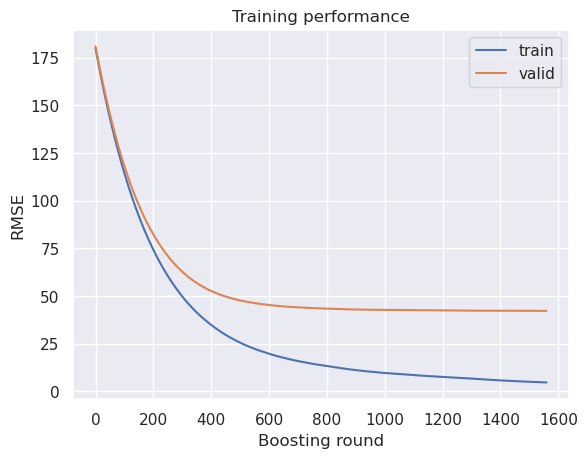

In [27]:
# 処理速度比較のためXGBoostの処理速度を計測する。
xgb_params = {
    'booster': 'gbtree',
    'eval_metric': 'rmse',
    'objective': 'reg:squarederror',
    "seed":31,
    'random_state': 42,
    "num_iterations":10000, # early stopping で止まるため大きめに設定しておけばよい
    "learning_rate": 0.005, #学習率
    "num_leaves":511,
    "max_depth":12,
    "min_data_in_leaf":10,
}

# 学習用データセットの作成（X_test,y_testは最後のpredict用の変数としてここでは使用しない）
dtrain =  xgb.DMatrix(X_train, label=y_train)  # 学習用
dvalid = xgb.DMatrix(X_valid, label=y_valid)  # early_stopping用
#学習
# 以下を参考にearly stoppingを10で設定
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4
# ステップごとの処理結果の保存コールバックで実施するよう仕様変更更
# https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.record_evaluation.html
verbose_eval = 0  # この数字を1にすると学習時のスコア推移がコマンドライン表示される
evals_result = {}
import time
starttime = time.time()
xgb = xgb.train(xgb_params,
                dtrain,
                num_boost_round=50000,
                early_stopping_rounds=10,
                evals=[(dtrain, 'train'), (dvalid, 'eval')],
                evals_result=evals_result)
elapse_train_time = time.time() - starttime
print("elapse train time is {}".format(elapse_train_time))

# スコア(RMSE)算出
starttime = time.time()
y_pred = xgb.predict(dvalid)
elapse_predict_time = time.time() - starttime
print("elapse predict time is {}".format(elapse_predict_time))

score_mlse = mean_squared_error(y_true=y_valid, y_pred=y_pred, squared=False)
print(f'RMSE={score_mlse}')
# MLSLEを算出するために、y_pred<0の場合に0を補完する
y_pred = np.where(y_pred < 0, 0, y_pred)
score_mlsle = mean_squared_log_error(y_true=y_valid, y_pred=y_pred, squared=False)
print(f'RMSLE={score_mlsle}')
plt.plot(evals_result['train']['rmse'], label='train')
plt.plot(evals_result['eval']['rmse'], label='valid')
plt.ylabel('RMSE')
plt.xlabel('Boosting round')
plt.title('Training performance')
# plt.set_ylim(0, 180)
plt.legend()
plt.show()

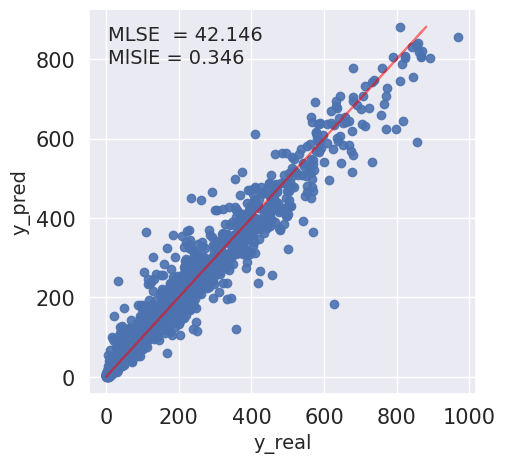

In [28]:
# テストデータで予測精度を確認
pred_df = pd.concat([y_valid.reset_index(drop=True), pd.Series(y_pred)], axis = 1)
pred_df.columns = ['y_real', 'y_pred']

Prediction_accuracy(pred_df,score_mlse,score_mlsle)

Text(0.05, 0.86, 'LightGBM = Orange')

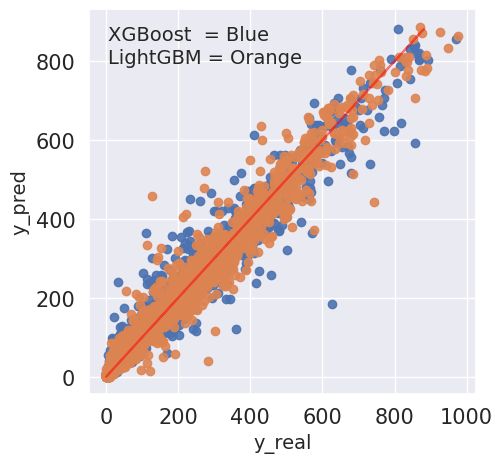

In [30]:
# テストデータで予測精度を確認
pred_df_xgb = pd.concat([y_valid.reset_index(drop=True), pd.Series(y_pred)], axis = 1)
pred_df_xgb.columns = ['y_real', 'y_pred']
pred_df_light
# 予測値グラフ化
    # MSE = mean_squared_error(pred_df['y_test'], pred_df['y_pred']) 
    # RMSE = np.sqrt(mean_squared_error(pred_df['y_test'], pred_df['y_pred']))
    # r2 = r2_score(pred_df['y_test'], pred_df['y_pred'])
plt.figure(figsize = (5,5))
ax = plt.subplot(111)
ax.scatter('y_real', 'y_pred', data = pred_df_xgb,alpha=0.9)
ax.scatter('y_real', 'y_pred', data = pred_df_light,alpha=0.9)
ax.set_xlabel('y_real', fontsize = 14)
ax.set_ylabel('y_pred', fontsize = 14)
plt.tick_params(labelsize = 15)
ax.plot('y_pred','y_pred',data=pred_df,color='red',alpha =0.5)
plt.text(0.05, 0.92, 'XGBoost  = Blue',transform = ax.transAxes, fontsize = 14)
plt.text(0.05, 0.86, 'LightGBM = Orange',transform = ax.transAxes, fontsize = 14)
# plt.text(0.05, 0.80, 'R²   = {}'.format(str(round(r2,3))),transform = ax.transAxes, fontsize = 14)

